# Predicting Bullying Amongst Students In School.

The goal of the project is to create a machine learning model that can well identify whether a student is being bullied or not.

In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer 
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")

In [2]:
bullying = pd.read_csv("bullying.csv")

In [3]:
bullying.head()

,record,bullied_in_school,bullied_not_school,cyber_bullied,custom_age,sex,physically_attacked,physical_fighting,felt_lonely,close_friends,missed_school,other_students_kind_and_helpful,parents_understand_problems,most_of_the_time_or_always_felt_lonely,missed_classes,were_underweight,were_overweight,were_obese
0,1,Yes,Yes,NaN,13 years old,Female,0 times,0 times,Always,2,10 or more days,Never,Always,Yes,Yes,NaN,NaN,NaN
1,2,No,No,No,13 years old,Female,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,NaN,NaN,NaN
2,3,No,No,No,14 years old,Male,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,No,No,No
3,4,No,No,No,16 years old,Male,0 times,2 or 3 times,Never,3 or more,0 days,Sometimes,NaN,No,No,No,No,No
4,5,No,No,No,13 years old,Female,0 times,0 times,Rarely,3 or more,0 days,Most of the time,Most of the time,No,No,NaN,NaN,NaN


###  Cleaning Data and Handling Null Values

In [4]:
bullying.isnull().sum()/bullying.shape[0] * 100

record                                     0.000000
bullied_in_school                          2.174409
bullied_not_school                         0.858181
cyber_bullied                              1.002088
custom_age                                 0.189537
sex                                        0.940664
physically_attacked                        0.421193
physical_fighting                          0.470332
felt_lonely                                0.642319
close_friends                              1.888349
missed_school                              3.271266
other_students_kind_and_helpful            2.736000
parents_understand_problems                4.164546
most_of_the_time_or_always_felt_lonely     0.642319
missed_classes                             3.271266
were_underweight                          36.729787
were_overweight                           36.729787
were_obese                                36.729787
dtype: float64

The columns with more than 5% of null values are going t be dropped. This includes the `were_obese`, `were_underweight`, `were_overweight` columns. From the EDA done which can be found <a href="https://github.com/yickysan/MLops/blob/main/notebook/Exploratory%20data%20analysis.ipynb">here</a> , these columns are not indicative of bullying. For the rest of the dataset, the null entries will be dropped. 

In [5]:
bullying.drop(
    ["were_obese", "were_underweight", "were_overweight"],
    axis=1, inplace=True
)
bullying.dropna(inplace=True)

In [6]:
bullying.isnull().sum()

record                                    0
bullied_in_school                         0
bullied_not_school                        0
cyber_bullied                             0
custom_age                                0
sex                                       0
physically_attacked                       0
physical_fighting                         0
felt_lonely                               0
close_friends                             0
missed_school                             0
other_students_kind_and_helpful           0
parents_understand_problems               0
most_of_the_time_or_always_felt_lonely    0
missed_classes                            0
dtype: int64

In [7]:
bullying.drop(
    ["record", "most_of_the_time_or_always_felt_lonely", "missed_classes"],
    axis=1, inplace=True
)
bullying["custom_age"] = bullying["custom_age"].str.extract("(\d+)").astype(int)
bullying["close_friends"] = bullying["close_friends"].str.extract("(\d+)").astype(int)
bullying["missed_school"] = bullying["missed_school"].str.extract("(\d+)").astype(int)

In [8]:
bullying.shape

(50754, 12)

## Creating Features and Target Variable

In [8]:
y = bullying["bullied_in_school"].astype("category").cat.codes
X = bullying.copy().drop("bullied_in_school", axis=1)
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = X[col].astype("category").cat.codes

In [9]:
y.value_counts(normalize=True)

0    0.789731
1    0.210269
Name: proportion, dtype: float64

The data set is imbalanced with only 21% of the data being students that were bullied.

In [10]:
kbest = SelectKBest(chi2, k = "all")
X = kbest.fit_transform(X, y)

In [11]:
kbest.get_feature_names_out()

array(['bullied_not_school', 'cyber_bullied', 'custom_age', 'sex',
       'physically_attacked', 'physical_fighting', 'felt_lonely',
       'close_friends', 'missed_school',
       'other_students_kind_and_helpful', 'parents_understand_problems'],
      dtype=object)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Evaluating Models

In [13]:
scale_pos_weight = y.value_counts().values[0]/y.value_counts().values[1]

The `scale_pos_weight` argument for the xgboost model accounts for the imbalance nature of the dataset. As a rule of thumb, a good `scale_pos_weight` value is the ratio of the majority class over the minority class. For the other models, the `class_weight` argument will be set to `balanced`.

In [15]:
models = {
    "logreg" : LogisticRegression(class_weight="balanced"),
    "randomforest" : RandomForestClassifier(class_weight="balanced", random_state=1),
    "adaboost" : AdaBoostClassifier(random_state=1),
    "xgboost" : XGBClassifier(scale_pos_weight = scale_pos_weight, random_state=1),
    "svm" : SVC(class_weight="balanced", random_state=1),
    "tree" : DecisionTreeClassifier(random_state=1, class_weight="balanced")
}

In [16]:
model_performance = {}
# loop through each item in the dictionary and use the models for prediction
for k, v in models.items():
    model_dict = {}
    model_name = k
    model = v
    model.fit(X_train, y_train) # fit the model with training data
    pred = model.predict(X_test)
    model_dict["auc_score"] = roc_auc_score(y_test, pred)
    model_dict["precision_score"] = precision_score(y_test, pred)
    model_dict["recall_score"] = recall_score(y_test, pred)
    model_dict["confusion_matrix"] = confusion_matrix(y_test, pred)
    model_performance[model_name] = model_dict

In [17]:
for key in model_performance.keys():
    print(key, ": %.4f" %model_performance[key]["auc_score"], "\n", 
            model_performance[key]["confusion_matrix"])
    print("---------------------------")

logreg : 0.7095 
 [[6257 1712]
 [ 799 1383]]
---------------------------
randomforest : 0.6221 
 [[7015  954]
 [1388  794]]
---------------------------
adaboost : 0.6239 
 [[7580  389]
 [1535  647]]
---------------------------
xgboost : 0.7018 
 [[6156 1813]
 [ 805 1377]]
---------------------------
svm : 0.6944 
 [[6750 1219]
 [1000 1182]]
---------------------------
tree : 0.6132 
 [[6365 1604]
 [1249  933]]
---------------------------


The xgboost and logistic regresion models performed best. Some hyperparameter tuning will be performed to see if the model performance can be improved.

## Hyperparameter Optimization.

### XGB Hyperparameter Optimization

In [18]:
learning_rate = [i/100 for i in range(1, 11)]
gamma = [i/10 for i in range(5)]
max_depth = range(3, 10, 2)
min_child_weight = range(1, 8, 2)
reg_alpha =[1e-5, 1e-2, 0.1, 1, 100]
subsample =[i/100 for i in range(75, 90, 5)]
colsample_bytree = [i/100 for i in range(75, 90, 5)]
scale_pos_weights = [1, 2, 3, 4, scale_pos_weight]

xgb_model = models["xgboost"]



In [19]:
%%time
xgb_param = {"n_estimators" : range(100, 550, 50)}
xgb_gridsearch = GridSearchCV(xgb_model, xgb_param, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch.fit(X, y)

print(xgb_gridsearch.best_score_)
print(xgb_gridsearch.best_params_)

0.7579010292094389
{'n_estimators': 100}
CPU times: total: 17.1 s
Wall time: 16min 51s


In [20]:
%%time
xgb_model2 = xgb_gridsearch.best_estimator_
xgb_param2 = {"max_depth" : max_depth,
              "min_child_weight" : min_child_weight
             }
xgb_gridsearch2 = GridSearchCV(xgb_model2, xgb_param2, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch2.fit(X, y)

print(xgb_gridsearch2.best_score_)
print(xgb_gridsearch2.best_params_)

0.7755177408726329
{'max_depth': 3, 'min_child_weight': 7}
CPU times: total: 9.58 s
Wall time: 10min 14s


In [21]:
%%time
xgb_model3 = xgb_gridsearch2.best_estimator_
xgb_param3 = {"learning_rate" : learning_rate,
              "gamma" : gamma }
xgb_gridsearch3 = GridSearchCV(xgb_model3, xgb_param3, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch3.fit(X, y)

print(xgb_gridsearch3.best_score_)
print(xgb_gridsearch3.best_params_)

0.7769757808446022
{'gamma': 0.0, 'learning_rate': 0.08}
CPU times: total: 13.2 s
Wall time: 15min 32s


In [22]:
%%time
xgb_model4 = xgb_gridsearch3.best_estimator_
xgb_param4 = {"reg_alpha" : reg_alpha,
              "subsample" : subsample,}
xgb_gridsearch4 = GridSearchCV(xgb_model4, xgb_param4, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch4.fit(X, y)

print(xgb_gridsearch4.best_score_)
print(xgb_gridsearch4.best_params_)

0.7774898864224424
{'reg_alpha': 0.1, 'subsample': 0.75}
CPU times: total: 10.8 s
Wall time: 4min 56s


In [23]:
%%time
xgb_model5 = xgb_gridsearch4.best_estimator_
xgb_param5 = {"colsample_bytree" : colsample_bytree,
             "scale_pos_weight" : scale_pos_weights}
xgb_gridsearch5 = GridSearchCV(xgb_model5, xgb_param5, cv=10, scoring="roc_auc", n_jobs=-1)
xgb_gridsearch5.fit(X, y)

print(xgb_gridsearch5.best_score_)
print(xgb_gridsearch5.best_params_)

0.7771881407915773
{'colsample_bytree': 0.85, 'scale_pos_weight': 2}
CPU times: total: 10.8 s
Wall time: 4min 21s


In [24]:
xgb_gridsearch4.best_estimator_.fit(X_train, y_train)
xgb_pred = xgb_gridsearch4.best_estimator_.predict(X_test)

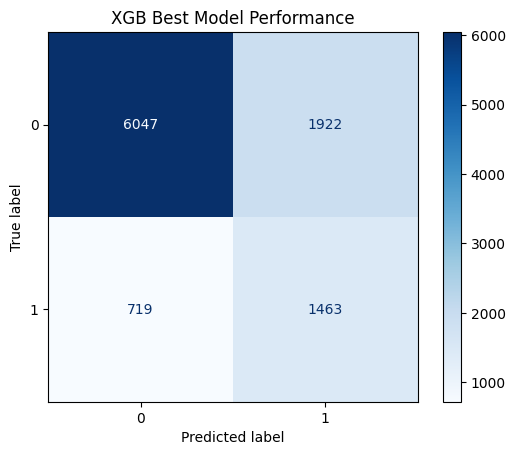

auc_score: 0.7147


In [25]:
xgb_model_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, xgb_pred))
xgb_model_plot.plot(cmap=plt.cm.Blues)
xgb_model_plot.ax_.set_title("XGB Best Model Performance")
plt.show()

print(
    "auc_score: %.4f" % roc_auc_score(y_test, xgb_pred)
)

After performing hyperparameter tuning on the xgboost model, there is a slight impovement and the model can better predict the minority class but the difference in model performance isn't really significant.

### LogisticRegression Hyperparameter Tuning

In [26]:
lgr_clf = models["logreg"]

fit_intercept = [True, False]
penalty = ["l1", "l2", "elasticnet"]
solver = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
class_weights = [{0:1, 1:99}, {0:10, 1:90}, {0:5, 1:95},
                {0:15, 1:85}, {0:20, 1:80}, {0:25,1:75},
                {0:19, 1:71}, {0:21, 1:69}, {0:11, 1:79}]

In [27]:
%%time
lgr_param = {"penalty" : penalty,
            "solver" : solver,
            "fit_intercept" : fit_intercept}
lgr_gridsearch = GridSearchCV(lgr_clf, lgr_param, cv=10, scoring="roc_auc", n_jobs=-1)
lgr_gridsearch.fit(X, y)

print(lgr_gridsearch.best_score_)
print(lgr_gridsearch.best_params_)

0.7606219943957291
{'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
CPU times: total: 3.62 s
Wall time: 1min 41s


In [28]:
%%time
lgr_clf2 = lgr_gridsearch.best_estimator_
lgr_param2 = {"class_weight" : class_weights}
lgr_gridsearch2 = GridSearchCV(lgr_clf2, lgr_param2, cv=10, scoring="roc_auc", n_jobs=-1)
lgr_gridsearch2.fit(X, y)

print(lgr_gridsearch2.best_score_)
print(lgr_gridsearch2.best_params_)

0.7608458939101563
{'class_weight': {0: 1, 1: 99}}
CPU times: total: 1.55 s
Wall time: 28 s


In [34]:
lgr_gridsearch2.best_estimator_.fit(X_train, y_train)
lgr_pred = lgr_gridsearch2.best_estimator_.predict(X_test)
print(roc_auc_score(y_test, lgr_pred))
print(confusion_matrix(y_test, lgr_pred))

0.5
[[   0 7969]
 [   0 2182]]


Despite the second logistic regression model performing better with the class weights in the grid_search. It doesn't do a good job at predicting the test data.

In [29]:
lgr_gridsearch.best_estimator_.fit(X_train, y_train)
lgr_pred = lgr_gridsearch.best_estimator_.predict(X_test)
print(roc_auc_score(y_test, lgr_pred))
print(confusion_matrix(y_test, lgr_pred))

0.7092029621198275
[[6256 1713]
 [ 800 1382]]


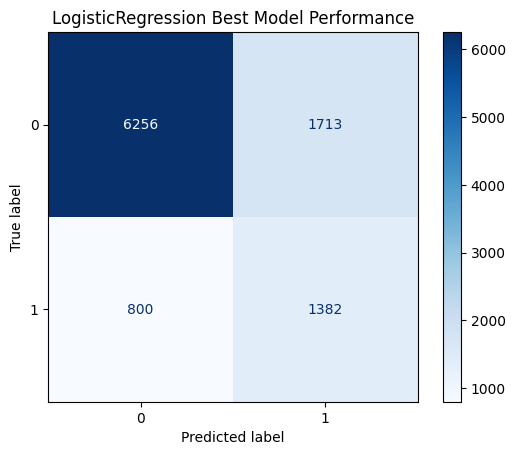

auc_score: 0.7092


In [30]:
lgr_model_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, lgr_pred))
lgr_model_plot.plot(cmap=plt.cm.Blues)
lgr_model_plot.ax_.set_title("LogisticRegression Best Model Performance")
plt.show()

print(
    "auc_score: %.4f" %roc_auc_score(y_test, lgr_pred)
)

The logistic regression model performed slightly worse than the xgboost one and didn't show any improvement from the original logistic regression model. Overall, both the xgboost and logistic regression models aren't too great. Next a custom model combining both xgboost and logistic regression will be used to see if there will be any improvement.

## Creating Custom Model.

In [31]:
class CustomBagger:
    """
    Function to make predictions with two models using bagging technique.
    
    This function utilises one `sklearn.linear_model.LogisticRegression` model and an `xgboost.XGBClassifier` model to make
    predictions on the dataset. Predictions are made by taking the average probability prediction of both models.
    A value of 1 will be predicted if the probability is greater than 0.5, otherwise it will be 0.
    
    Attributes:
    ----------
    model_1 : 
        either an `xgboost.XGBClassifier` model or an `sklearn.linear_model.LogisticRegression` model
        
    model_2 :
        either an `xgboost.XGBClassifier` model or an `sklearn.linear_model.LogisticRegression` model
        
    Methods:
    -------
    fit(X_train, y_train)
        This method splits the dataset equally and fits the models with each half of the split dataset
        
    predict(y_test)
        This method returns the average prediction of both models
    """
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        
    def fit(self, X_train, y_train):
        size = X_train.shape[0] // 2 # splitting the train data into equal parts to fit in the two models
        X_train_1, y_train_1 = X_train[:20301], y_train[:20301]
        X_train_2, y_train_2 = X_train[20301:], y_train[20301:]
        
        self.model_1 = self.model_1.fit(X_train_1, y_train_1)
        self.model_2 = self.model_2.fit(X_train_2, y_train_2)
        
    def predict(self, y_test):
        model_1_pred = pd.Series(self.model_1.predict_proba(y_test)[:, 1], name="model_1_pred")
        model_2_pred = pd.Series(self.model_2.predict_proba(y_test)[:, 1], name="model_2_pred")
        pred_table = pd.concat([model_1_pred, model_2_pred], axis=1) # creates a pandas data frame with predicttions of both model
        predictions = pred_table.mean(axis=1) # takes the average of both predictions
        predictions = predictions.apply(lambda x: 1 if x > 0.5 else 0).values # predicts 1 for probability greater than 0.55
        
        return predictions
        
        

In [32]:
model_1 = xgb_gridsearch4.best_estimator_
model_2 = lgr_gridsearch.best_estimator_

custom_bagger = CustomBagger(model_1, model_2)

custom_bagger.fit(X_train, y_train)

preds = custom_bagger.predict(X_test)

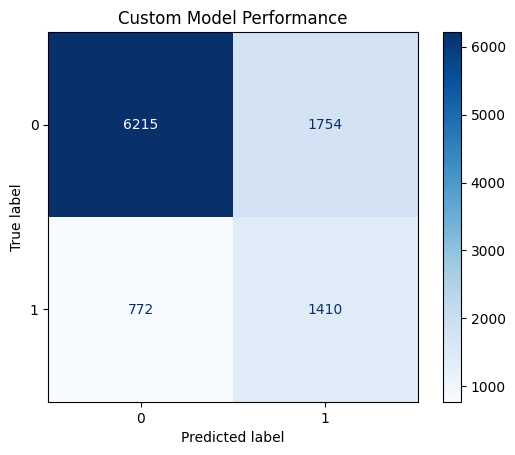

auc_score: 0.7130


In [33]:
custom_model_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, preds))
custom_model_plot.plot(cmap=plt.cm.Blues)
custom_model_plot.ax_.set_title("Custom Model Performance")
plt.show()

print(
    "auc_score: %.4f" %roc_auc_score(y_test, preds)
)

The custom  model sits in between the logistic regression model and the xgboost model. Overall there isn't a significant difference between all three models.

## Predicting Using Synthetic Minority Over Sampling (SMOTE) and Random Under Sampling

A combinantion of both smote over sampling and a random undersampling wil be performed on the train dataset before making predictions on the test dataset.

### Over Sampling

In [34]:
over_sampler = SMOTE(sampling_strategy=0.8)
#under_sampler = RandomUnderSampler(sampling_strategy=0.8)
#pipe = Pipeline([("over", over_sampler), ("under", under_sampler)])
X_s, y_s = over_sampler.fit_resample(X_train, y_train)

In [35]:
y_s.value_counts()

0    32113
1    25690
Name: count, dtype: int64

In [36]:
# the s in the variale names is to indicate they are from the resampled data
models_s = {
    "logreg" : LogisticRegression(),
    "randomforest" : RandomForestClassifier(random_state=1),
    "adaboost" : AdaBoostClassifier(random_state=1),
    "xgboost" : XGBClassifier(random_state=1),
    "svm" : SVC(random_state=1)
}

In [37]:
model_performance_s = {}
# loop through each item in the dictionary and use the models for prediction
for k, v in models_s.items():
    model_dict_s = {}
    model_name_s = k
    model_s = v
    model_s.fit(X_s, y_s) # fit the model with training data
    pred_s = model_s.predict(X_test)
    model_dict_s["auc_score"] = roc_auc_score(y_test, pred_s)
    model_dict_s["precision_score"] = precision_score(y_test, pred_s)
    model_dict_s["recall_score"] = recall_score(y_test, pred_s)
    model_dict_s["confusion_matrix"] = confusion_matrix(y_test, pred_s)
    model_performance_s[model_name_s] = model_dict_s

In [38]:
for key in model_performance_s.keys():
    print(key, ": %.4f" %model_performance_s[key]["auc_score"], "\n", 
            model_performance_s[key]["confusion_matrix"])
    print("---------------------------")

logreg : 0.6960 
 [[6550 1419]
 [ 938 1244]]
---------------------------
randomforest : 0.6447 
 [[6389 1580]
 [1118 1064]]
---------------------------
adaboost : 0.6992 
 [[6477 1492]
 [ 904 1278]]
---------------------------
xgboost : 0.6758 
 [[6450 1519]
 [ 999 1183]]
---------------------------
svm : 0.6920 
 [[6808 1161]
 [1026 1156]]
---------------------------


The over sampled dataset didn't show any improvement. Infact, it performed worse than the models wihtout over sampled data. Only the adaboost model improved when SMOTE over sampling was performed.

### Under Sampling.

In [40]:
under_sampler = RandomUnderSampler(sampling_strategy=0.8)
X_us, y_us = under_sampler.fit_resample(X_train, y_train)
y_us.value_counts()

0    10612
1     8490
Name: count, dtype: int64

In [41]:
model_performance_us = {}
# loop through each item in the dictionary and use the models for prediction
for k, v in models_s.items():
    model_dict_us = {}
    model_name_us = k
    model_us = v
    model_us.fit(X_us, y_us) # fit the model with training data
    pred_us = model_us.predict(X_test)
    model_dict_us["auc_score"] = roc_auc_score(y_test, pred_us)
    model_dict_us["precision_score"] = precision_score(y_test, pred_us)
    model_dict_us["recall_score"] = recall_score(y_test, pred_us)
    model_dict_us["confusion_matrix"] = confusion_matrix(y_test, pred_us)
    model_performance_us[model_name_us] = model_dict_us

In [42]:
for key in model_performance_us.keys():
    print(key, ": %.4f" %model_performance_us[key]["auc_score"], "\n", 
            model_performance_us[key]["confusion_matrix"])
    print("---------------------------")

logreg : 0.7011 
 [[6583 1386]
 [ 925 1257]]
---------------------------
randomforest : 0.6824 
 [[5883 2086]
 [ 815 1367]]
---------------------------
adaboost : 0.7026 
 [[6542 1427]
 [ 907 1275]]
---------------------------
xgboost : 0.6956 
 [[6273 1696]
 [ 864 1318]]
---------------------------
svm : 0.6857 
 [[6885 1084]
 [1075 1107]]
---------------------------


With the exception of the adaboost, the under sampled dataset produced a worse result than than the regular dataset. Finally a combination of both over sampling and under sampling will be performed to see how well the models will improve.

In [43]:
over_sampler = SMOTE(sampling_strategy=0.6)
under_sampler = RandomUnderSampler(sampling_strategy=0.8)
pipe = Pipeline([("over", over_sampler), ("under", under_sampler)])
X_ds, y_ds = pipe.fit_resample(X_train, y_train)
y_ds.value_counts()

0    24083
1    19267
Name: count, dtype: int64

In [44]:
model_performance_ds = {}
# loop through each item in the dictionary and use the models for prediction
for k, v in models_s.items():
    model_dict_ds = {}
    model_name_ds = k
    model_ds = v
    model_ds.fit(X_ds, y_ds) # fit the model with training data
    pred_ds = model_ds.predict(X_test)
    model_dict_ds["auc_score"] = roc_auc_score(y_test, pred_ds)
    model_dict_ds["precision_score"] = precision_score(y_test, pred_ds)
    model_dict_ds["recall_score"] = recall_score(y_test, pred_ds)
    model_dict_ds["confusion_matrix"] = confusion_matrix(y_test, pred_ds)
    model_performance_ds[model_name_ds] = model_dict_ds

In [45]:
for key in model_performance_ds.keys():
    print(key, ": %.4f" %model_performance_ds[key]["auc_score"], "\n", 
            model_performance_ds[key]["confusion_matrix"])
    print("---------------------------")

logreg : 0.6984 
 [[6555 1414]
 [ 929 1253]]
---------------------------
randomforest : 0.6592 
 [[6307 1662]
 [1032 1150]]
---------------------------
adaboost : 0.7026 
 [[6494 1475]
 [ 894 1288]]
---------------------------
xgboost : 0.6876 
 [[6415 1554]
 [ 938 1244]]
---------------------------
svm : 0.6915 
 [[6810 1159]
 [1029 1153]]
---------------------------


Like the other resampling techniques performed, only the adaboost model benefits significantly from the combination of both under sampling and over sampling.

## Conclusion
There are few takeaways that can be gotten from the performances of the different models.
* The xgboost did the best job in predicting whether a student will be bullied or not. It had the highest true positive predictions and the least false negative predictions.
* When the data was resampled, it didn't show any significant improvement in how the models performed. In fact the models performed worse on the resampled dataset.
* Only the adaboost model showed improvement on the resampled dataset matching closely the performance of the logistic regression model and the xgboost model on the non-resampled dataset.